In [1]:
import nest_asyncio
from langgraph.graph import START, StateGraph
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod
from typing import Literal
from langchain_core.messages import AIMessage
import os
from openai import OpenAI
from dotenv import load_dotenv
from nodes import assistant, summarize_security_events, execute_tools, save_iteration
from state import HoneypotStateReact
import memory

nest_asyncio.apply()
import benchmark as b



def display_graph(graph, width=500, height=600):

    png_bytes = graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)

    display(Image(data=png_bytes, format="png", width=width, height=height)
)

def is_api_key_valid():
    try:
        client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
        response = client.responses.create(
            model="gpt-3.5-turbo",
            instructions="Test API key",
            input="Test API key",
            max_output_tokens=16,
            timeout=10
            )
    except Exception as e:
        print(f"Error: {e}")
        return False
    else:
        return True

In [2]:

# Load environment variables
load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
#  Check the validity of the API key
api_key_valid = is_api_key_valid()
print("API key is valid:", api_key_valid)

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/responses "HTTP/1.1 200 OK"


API key is valid: True


# Memory implementation

In [3]:
def should_continue_from_assistant(state: HoneypotStateReact) -> Literal["tools", "save_iteration", "__end__"]:
    last_message = state.messages[-1]
    
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    
    # Check if we have enough data and no cleanup flag
    if (len(state.security_events_summary) > 1 and len(state.messages) > 1 and not state.cleanup_flag):
        return "save_iteration"

    return "__end__"


def should_continue_from_tools(state: HoneypotStateReact) -> Literal["summarize_security_events", "assistant"]:
    # After tools are executed, decide where to go next
    if state.security_events and not state.security_events_summary:
        return "summarize_security_events"
    return "assistant"


In [4]:
def cleanup_messages(state: HoneypotStateReact):
    """Clean up messages - simplified for notebook usage"""
    print("Ending iteration...")
    
    # For notebook usage, don't flush state since each epoch starts fresh
    # Just mark cleanup as complete
    return {
        "cleanup_flag": True
    }

In [5]:
def build_react_graph():
    builder = StateGraph(HoneypotStateReact)
    
    # Add nodes (remove save_iteration node)
    builder.add_node("assistant", assistant)
    builder.add_node("tools", execute_tools)
    builder.add_node("summarize_security_events", summarize_security_events)
    builder.add_node("save_iteration", save_iteration)
    builder.add_node("cleanup", cleanup_messages)
    
    # Add edges
    builder.add_edge(START, "assistant")
    builder.add_conditional_edges("assistant", should_continue_from_assistant)
    builder.add_conditional_edges("tools", should_continue_from_tools)
    builder.add_edge("summarize_security_events", "assistant")
    builder.add_edge("save_iteration", "cleanup")
    builder.add_edge("cleanup", "__end__")
        
    return builder.compile()

INFO:pyppeteer.launcher:Browser listening on: ws://127.0.0.1:34151/devtools/browser/df02b5d9-5965-45b9-a88d-41b87076014d
INFO:pyppeteer.launcher:terminate chrome process...


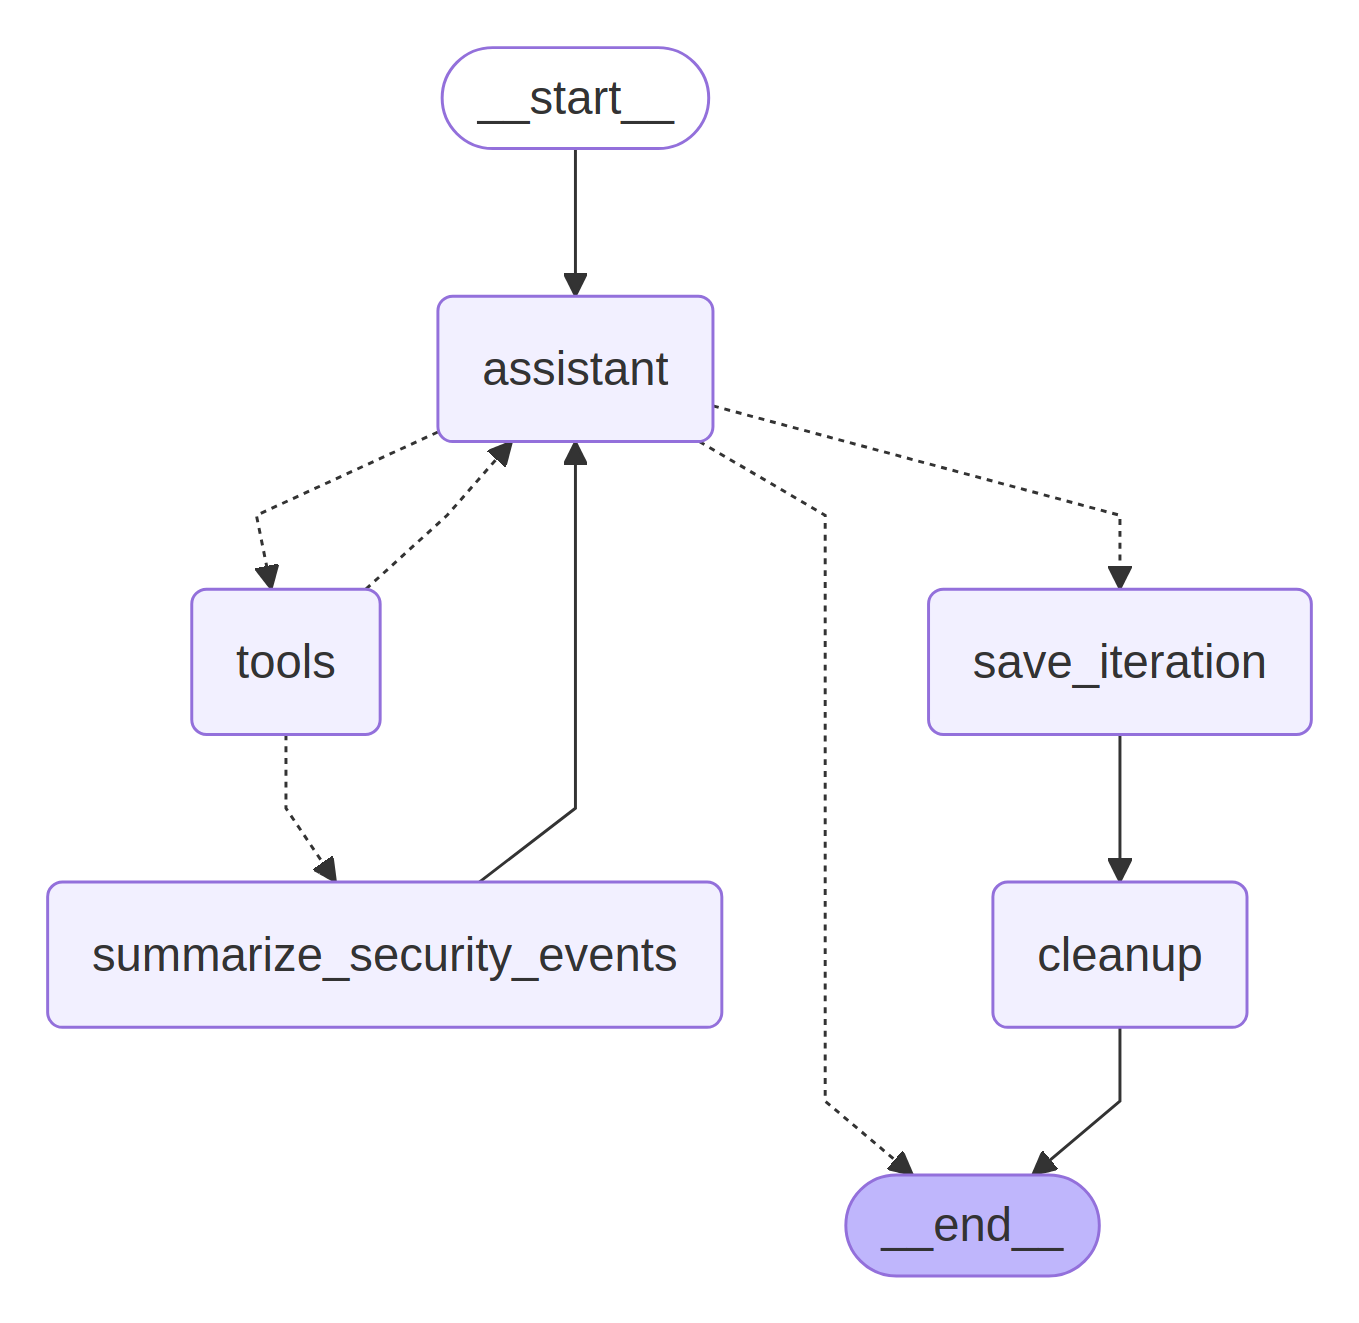

In [6]:
graph = build_react_graph()
display_graph(graph)

In [7]:
# episodic_memory = memory.EpisodicMemory()
# initial_state = HoneypotStateReact(
#     messages="Analyze the honeypot data, infer the attack graph for the current epoch if applicable change firewall rules to engage attacker. GitLab proxy is not a honeypot, it is a relay. Track exploitation only on the GitLab honeypot IP"
# )
# response = graph.invoke(initial_state, config={"configurable": {"store" : episodic_memory, "promptAssistant": "AttackGraphInference"}})

In [8]:
# for m in response['messages']:
#     m.pretty_print()

# Benchmark

## Gitlab + Struts 

In [12]:
import memory
episodic_memory = memory.EpisodicMemory()

config_dict = {
            "max_epochs": 10,
            "attack_duration": 200,
            "monitor_accumulation_wait": 1,
            "firewall_update_wait": 2,
            "between_epoch_wait": 1,
            "stop_on_lockdown": True,
            "dir_name": "Test Gitlab + Struts - Assistant + Summary Fast Log"
        }

In [ ]:
runner = b.BenchmarkRunner(config_dict, episodic_memory=episodic_memory)
initial_state = HoneypotStateReact(
    messages="Analyze the network using the tools at your disposal and follow the instruction to add firewall rules"
)
def my_agent_executor(epoch_num: int):
    print(f"Executing agent for epoch {epoch_num}")
    return graph.invoke(initial_state, config={"configurable": {"store" : episodic_memory, "promptAssistant": "AttackGraphInference"}})

results = runner.run(my_agent_executor)

INFO:benchmark.Orchestrator:Starting benchmark run


INFO:benchmark.AttackerController:Found existing attacker container: attacker
INFO:benchmark.AttackerController:Successfully connected to attacker container
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 1 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-1] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-1] ['/attacker/scripts/manager_exploit.py', '1']
INFO:benchmark.AttackerController:[ATTACK-1] [*] Launching exploit manager...
INFO:benchmark.AttackerController:[ATTACK-1] [*] Scanning 172.20.0.0/25 for open ports...
INFO:benchmark.AttackerController:[ATTACK-1] [+] Detected v

Executing agent for epoch 1


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 192.168.100.0/24 -> 172.20.0.6:80 (tcp)
INFO:tools:Adding allow rule: ALLOW 172.20.0.6 -> 192.168.100.0/24 (all)
INFO:tools:Adding allow rule: ALLOW 192.168.100.0/24 -> 172.20.0.5 (all)
INFO:tools:Adding allow rule: ALLOW 172.20.0.5 -> 192.168.100.0/24 (all)
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_1. Total iterations: 1
INFO:benchmark:Memory from agent: {'id': 'iteration_1', 'iteration_number': 1, 'timestamp': 1753357028, 'datetime': '2025-07-24T13:37:08.525581', 'currently_exposed': '172.20.0.5:80'

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab + Struts - Assistant + Summary Fast Log/epoch_001.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 2 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-2] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-2] ['/attacker/scripts/manager_exploit.py', '2']
INFO:benchmark.AttackerController:[ATTACK-2] [*] Launching exploit m

Executing agent for epoch 2
Loaded 1 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_2. Total iterations: 2
INFO:benchmark:Memory from agent: {'id': 'iteration_2', 'iteration_number': 2, 'timestamp': 1753357100, 'datetime': '2025-07-24T13:38:20.823435', 'currently_exposed': '172.20.0.5:80', 'rules_added': [], 'honeypots_exploitation': {'172.20.0.5': {'percentage': 33, 'service': 'gitlab', 'status': 'reconnaissance'}, '172.20.0.2': {'percentage': 0, 'service': 'struts2', 'status': 'unexposed'}}, 'decision_rationale': 'Attacker interaction with only the Gitlab honeypot and proxy (over HTTP/80 and multiple TCP services) is confirmed; reconnaissance (33%) is fully evidenc

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab + Struts - Assistant + Summary Fast Log/epoch_002.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 3 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-3] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-3] ['/attacker/scripts/manager_exploit.py', '3']
INFO:benchmark.AttackerController:[ATTACK-3] [*] Launching exploit m

Executing agent for epoch 3
Loaded 2 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_3. Total iterations: 3
INFO:benchmark:Memory from agent: {'id': 'iteration_3', 'iteration_number': 3, 'timestamp': 1753357155, 'datetime': '2025-07-24T13:39:15.504037', 'currently_exposed': '172.20.0.5:80', 'rules_added': [], 'honeypots_exploitation': {'172.20.0.5': {'percentage': 66, 'service': 'gitlab', 'status': 'compromise'}, '172.20.0.2': {'percentage': 0, 'service': 'struts2', 'status': 'unexposed'}}, 'decision_rationale': 'Monotonic progression is enforced: only the Gitlab honeypot is exposed, and attacker activity has reached compromise (66%) due to successful post-auth compro

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab + Struts - Assistant + Summary Fast Log/epoch_003.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 4 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-4] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-4] ['/attacker/scripts/manager_exploit.py', '4']
INFO:benchmark.AttackerController:[ATTACK-4] [*] Launching exploit m

Executing agent for epoch 4
Loaded 3 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 192.168.100.0/24 -> 172.20.0.2:8080 (tcp)
INFO:tools:Adding allow rule: ALLOW 172.20.0.2 -> 192.168.100.0/24 (all)
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_4. Total iterations: 4
INFO:benchmark:Memory from agent: {'id': 'iteration_4', 'iteration_number': 4, 'timestamp': 1753357235, 'datetime': '2025-07-24T13:40:35.173771', 'currently_exposed': '172.20.0.2:8080', 'rules_added': ['ALLOW 192.168.100.0/24 -> 172.20.0.2:8080 (tcp)', 'ALLOW 172.20.0.2 -> 192.168.100.0/24 (all)'], 'honeypots_exploitation': 

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab + Struts - Assistant + Summary Fast Log/epoch_004.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 5 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-5] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-5] ['/attacker/scripts/manager_exploit.py', '5']
INFO:benchmark.AttackerController:[ATTACK-5] [*] Launching exploit m

Executing agent for epoch 5
Loaded 4 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_5. Total iterations: 5
INFO:benchmark:Memory from agent: {'id': 'iteration_5', 'iteration_number': 5, 'timestamp': 1753357378, 'datetime': '2025-07-24T13:42:58.846022', 'currently_exposed': '172.20.0.2:8080', 'rules_added': [], 'honeypots_exploitation': {'172.20.0.5': {'percentage': 100, 'service': 'gitlab', 'status': 'full_control'}, '172.20.0.2': {'percentage': 66, 'service': 'struts2', 'status': 'compromise'}}, 'decision_rationale': 'High-severity RCE and post-exploitation events demonstrate attack progression to 66% on Struts2; memory rules and security evidence support only incre

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab + Struts - Assistant + Summary Fast Log/epoch_005.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 6 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-6] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-6] ['/attacker/scripts/manager_exploit.py', '6']
INFO:benchmark.AttackerController:[ATTACK-6] [*] Launching exploit m

Executing agent for epoch 6
Loaded 5 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_6. Total iterations: 6
INFO:benchmark:Memory from agent: {'id': 'iteration_6', 'iteration_number': 6, 'timestamp': 1753357512, 'datetime': '2025-07-24T13:45:12.996183', 'currently_exposed': '172.20.0.2:8080', 'rules_added': [], 'honeypots_exploitation': {'172.20.0.5': {'percentage': 100, 'service': 'gitlab', 'status': 'full_control'}, '172.20.0.2': {'percentage': 100, 'service': 'struts2', 'status': 'full_control'}}, 'decision_rationale': 'Both Gitlab and Struts2 honeypots have reached 100% exploitation, with monotonic progression and abundant evidence of advanced attacker control. No

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab + Struts - Assistant + Summary Fast Log/epoch_006.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 7 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-7] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-7] ['/attacker/scripts/manager_exploit.py', '7']
INFO:benchmark.AttackerController:[ATTACK-7] [*] Launching exploit m

Executing agent for epoch 7
Loaded 6 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding block rule: ALLOW 192.168.100.0/24 -> 172.20.0.0/24 (all)
INFO:tools:Removing firewall rules: [1, 2, 3, 4, 5, 6]
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_7. Total iterations: 7
INFO:benchmark:Memory from agent: {'id': 'iteration_7', 'iteration_number': 7, 'timestamp': 1753357584, 'datetime': '2025-07-24T13:46:24.570056', 'currently_exposed': 'NONE', 'rules_added': ['ALLOW 192.168.100.0/24 -> 172.20.0.0/24 (all)'], 'honeypots_exploitation': {'172.20.0.5': {'percentage': 100, 'service': 'gitlab', 'status': 'full_control

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Gitlab + Struts - Assistant + Summary Fast Log/epoch_007.json
INFO:benchmark.Orchestrator:Lockdown activated - stopping benchmark
INFO:benchmark.Orchestrator:Saved report to benchmark_results/Test Gitlab + Struts - Assistant + Summary Fast Log/benchmark_report.json
INFO:benchmark.Orchestrator:Cleaning up benchmark resources
INFO:benchmark.AttackerController:Stopped and removed attacker container


In [14]:
for i, message in enumerate(episodic_memory.get_recent_iterations(limit=10)):
    print("=" * 30)
    print(f"Iteration {i +1}")
    for k,v in message.value.items():
        if k in ['decision_rationale', 'justification', 'next_iteration_guidance']:
            print(f"{k}")
            v_str = str(v)
            for i in range(0, len(v_str), 120):
                print(v_str[i:i+120])
            print("\n")
    print("=" * 30 +"\n")

Iteration 1
decision_rationale
Begin engagement with Gitlab honeypot (via proxy) as it represents a complex, high-value service. No exposure previously
, so revealing it aligns with monotonic attack surface exploration. Rules ensure only Gitlab is accessible and interacti
on can be precisely monitored.


justification
Default deployment state requires exposing the first honeypot for attack surface exploration. Adding correct allow rules
 for Gitlab honeypot to enable controlled attacker access and enable probing in next iterations.


next_iteration_guidance
Monitor for reconnaissance or scan activity to determine if exploitation level can be advanced. Do not expose further ho
neypots until attacker activity on current target is detected.



Iteration 2
decision_rationale
Attacker interaction with only the Gitlab honeypot and proxy (over HTTP/80 and multiple TCP services) is confirmed; reco
nnaissance (33%) is fully evidenced via IDS log volume, port scans, and probing. Focus remains on

## Docker + Struts + Gitlab

In [ ]:
import memory
episodic_memory = memory.EpisodicMemory()

config_dict = {
            "max_epochs": 15,
            "attack_duration": 200,
            "monitor_accumulation_wait": 1,
            "firewall_update_wait": 2,
            "between_epoch_wait": 1,
            "stop_on_lockdown": True,
            "dir_name": "Test Docker + Struts + Gitlab - Exploitation maximizing"
        }

In [8]:
runner = b.BenchmarkRunner(config_dict, episodic_memory=episodic_memory)
initial_state = HoneypotStateReact(
    messages="Analyze the network using the tools at your disposal and follow the instruction to add firewall rules"
)
def my_agent_executor(epoch_num: int):
    print(f"Executing agent for epoch {epoch_num}")
    return graph.invoke(initial_state, config={"configurable": {"store" : episodic_memory}})

results = runner.run(my_agent_executor)

INFO:benchmark.Orchestrator:Starting benchmark run


INFO:benchmark.AttackerController:Found existing attacker container: attacker
INFO:benchmark.AttackerController:Successfully connected to attacker container
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 1 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-1] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-1] ['/attacker/scripts/manager_exploit.py', '1']
INFO:benchmark.AttackerController:[ATTACK-1] [*] Launching exploit manager...
INFO:benchmark.AttackerController:[ATTACK-1] [*] Scanning 172.20.0.0/25 for open ports...
INFO:benchmark.AttackerController:[ATTACK-1] [+] Detected v

Executing agent for epoch 1


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 192.168.100.0/24 -> 172.20.0.2:2375 (tcp)
INFO:tools:Adding allow rule: ALLOW 172.20.0.2 -> 192.168.100.0/24 (tcp)
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_1. Total iterations: 1
INFO:benchmark:Memory from agent: {'id': 'iteration_1', 'iteration_number': 1, 'timestamp': 1753527181, 'datetime': '2025-07-26T12:53:01.088635', 'currently_exposed': '172.20.0.2:2375', 'rules_added':

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Docker + Struts + Gitlab - Exploitation maximizing/epoch_001.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 2 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-2] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-2] ['/attacker/scripts/manager_exploit.py', '2']
INFO:benchmark.AttackerController:[ATTACK-2] [*] Launching explo

Executing agent for epoch 2
Loaded 1 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_2. Total iterations: 2
INFO:benchmark:Memory from agent: {'id': 'iteration_2', 'iteration_number': 2, 'timestamp': 1753527240, 'datetime': '2025-07-26T12:54:00.336833', 'currently_exposed': '172.20.0.2:2375', 'rules_added': [], 'honeypots_exploitation': {'172.20.0.2': {'percentage': 33, 'service': 'docker API', 'status': 'reconnaissance & initial exploitation events detected'}, '172.20.0.3': {'percentage': 0, 'service': 'struts2', 'status': 'unexposed'}, '172.20.0.6': {'percentage': 0, 'service': 'gitl

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Docker + Struts + Gitlab - Exploitation maximizing/epoch_002.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 3 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-3] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-3] ['/attacker/scripts/manager_exploit.py', '3']
INFO:benchmark.AttackerController:[ATTACK-3] [*] Launching explo

Executing agent for epoch 3
Loaded 2 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_3. Total iterations: 3
INFO:benchmark:Memory from agent: {'id': 'iteration_3', 'iteration_number': 3, 'timestamp': 1753527296, 'datetime': '2025-07-26T12:54:56.082961', 'currently_exposed': '172.20.0.2:2375', 'rules_added': [], 'honeypots_exploitation': {'172.20.0.2': {'percentage': 66, 'service': 'docker API', 'status': 'compromise: command execution, shell activity confirmed'}, '172.20.0.3': {'percentage': 0, 'service': 'struts2', 'status': 'unexposed'}, '172.20.0.6': {'percentage': 0, 'service': 'gi

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Docker + Struts + Gitlab - Exploitation maximizing/epoch_003.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 4 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-4] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-4] ['/attacker/scripts/manager_exploit.py', '4']
INFO:benchmark.AttackerController:[ATTACK-4] [*] Launching explo

Executing agent for epoch 4
Loaded 3 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 192.168.100.0/24 -> 172.20.0.7:80 (tcp)
INFO:tools:Adding allow rule: ALLOW 172.20.0.7 -> 192.168.100.0/24 (all)
INFO:tools:Adding allow rule: ALLOW 192.168.100.0/24 -> 172.20.0.6 (all)
INFO:tools:Adding allow rule: ALLOW 172.20.0.6 -> 192.168.100.0/24 (all)
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_4. Total iterations: 4
INFO:benchmark:Memory from agent: {'id': 'iteration_4', 

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Docker + Struts + Gitlab - Exploitation maximizing/epoch_004.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 5 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-5] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-5] ['/attacker/scripts/manager_exploit.py', '5']
INFO:benchmark.AttackerController:[ATTACK-5] [*] Launching explo

Executing agent for epoch 5
Loaded 4 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 172.20.0.3 -> 192.168.100.0/24 (all)
INFO:tools:Adding allow rule: ALLOW 192.168.100.0/24 -> 172.20.0.3:8080 (tcp)
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_5. Total iterations: 5
INFO:benchmark:Memory from agent: {'id': 'iteration_5', 'iteration_number': 5, 'timestamp': 1753527469, 'datetime': '2025-07-26T12:57:49.449128', 'currently_exposed': '172.20.0.2:2375, 172.20.0.6 (GIT

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Docker + Struts + Gitlab - Exploitation maximizing/epoch_005.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 6 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-6] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-6] ['/attacker/scripts/manager_exploit.py', '6']
INFO:benchmark.AttackerController:[ATTACK-6] [*] Launching explo

Executing agent for epoch 6
Loaded 5 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_6. Total iterations: 6
INFO:benchmark:Memory from agent: {'id': 'iteration_6', 'iteration_number': 6, 'timestamp': 1753527555, 'datetime': '2025-07-26T12:59:15.875992', 'currently_exposed': '172.20.0.2:2375, 172.20.0.6 (GITLAB, all ports via proxy), 172.20.0.3:8080', 'rules_added': [], 'honeypots_exploitation': {'172.20.0.2': {'percentage': 100, 'service': 'docker API', 'status': 'fully compromised (root/escalation, persistent C2, data discovery)'}, '172.20.0.6': {'percentage': 66, 'service': 'gitlab',

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Docker + Struts + Gitlab - Exploitation maximizing/epoch_006.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 7 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-7] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-7] ['/attacker/scripts/manager_exploit.py', '7']
INFO:benchmark.AttackerController:[ATTACK-7] [*] Launching explo

Executing agent for epoch 7
Loaded 6 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_7. Total iterations: 7
INFO:benchmark:Memory from agent: {'id': 'iteration_7', 'iteration_number': 7, 'timestamp': 1753527629, 'datetime': '2025-07-26T13:00:29.500183', 'currently_exposed': '172.20.0.2:2375, 172.20.0.6 (GITLAB, all ports via proxy), 172.20.0.3:8080', 'rules_added': [], 'honeypots_exploitation': {'172.20.0.2': {'percentage': 100, 'service': 'docker API', 'status': 'fully compromised (root, escalation, persistent C2, data discovery)'}, '172.20.0.6': {'percentage': 100, 'service': 'gitlab

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Docker + Struts + Gitlab - Exploitation maximizing/epoch_007.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 8 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-8] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-8] ['/attacker/scripts/manager_exploit.py', '8']
INFO:benchmark.AttackerController:[ATTACK-8] [*] Launching explo

Executing agent for epoch 8
Loaded 7 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding block rule: ALLOW 192.168.100.0/24 -> 172.20.0.0/24 (all)
INFO:tools:Removing firewall rules: [1, 2, 3, 4, 5, 6, 7, 8]
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_8. Total iterations: 8
INFO:benchmark:Memory from agent: {'id': 'iteration_8', 'iteration_number': 8, 'timestamp': 1753527717, 'datetime': '2025-07-26T13:01:57.668422', 'currently_exposed': 'NONE', 'rules_added': ['ALLOW 192.168.100.0/24

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Docker + Struts + Gitlab - Exploitation maximizing/epoch_008.json
INFO:benchmark.Orchestrator:Lockdown activated - stopping benchmark
INFO:benchmark.Orchestrator:Saved report to benchmark_results/Test Docker + Struts + Gitlab - Exploitation maximizing/benchmark_report.json
INFO:benchmark.Orchestrator:Cleaning up benchmark resources
INFO:benchmark.AttackerController:Stopped and removed attacker container


In [11]:
for i, message in enumerate(episodic_memory.get_recent_iterations(limit=10)):
    print("=" * 30)
    print(f"Iteration {i +1}")
    for k,v in message.value.items():
        if k in ['decision_rationale', 'justification', 'next_iteration_guidance']:
            print(f"{k}")
            v_str = str(v)
            for i in range(0, len(v_str), 120):
                print(v_str[i:i+120])
            print("\n")
    print("=" * 30 +"\n")

Iteration 1
decision_rationale
Protocol mandates single honeypot exposure with evidence-driven monotonic progression. No actionable threat detected; op
timal to continue monitoring until reconnaissance is observed.


justification
Continuing existing exposure of GitLab honeypot to attract attention; no evidence to justify progression or additional h
oneypot exposure. Only one honeypot (GitLab/cve-2021-22205-gitlab-1) is exposed per required protocol.


next_iteration_guidance
Monitor for initial scans or reconnaissance (first signs of engagement) against the GitLab honeypot before advancing exp
loitation percentage or rotating exposure. Ensure no policy drift or accidental dual exposure.



Iteration 2
decision_rationale
All health checks are positive; monitoring/logging are active. No threats or reconnaissance have occurred so the GitLab 
honeypot remains at 0% exploitation. Continued exposure is required to attract attacker interest and comply with phased,
 evidence-driven advancemen

## Test Docker + Struts + 2 decoys - Inference

In [8]:
import memory
episodic_memory = memory.EpisodicMemory()

config_dict = {
            "max_epochs": 15,
            "attack_duration": 200,
            "monitor_accumulation_wait": 1,
            "firewall_update_wait": 2,
            "between_epoch_wait": 1,
            "stop_on_lockdown": True,
            "dir_name": "Test Docker + Struts + 2 decoys - Inference + Summary Fast Log"
        }

In [9]:
runner = b.BenchmarkRunner(config_dict, episodic_memory=episodic_memory)
initial_state = HoneypotStateReact(
    messages="Analyze the network using the tools at your disposal and follow the instruction to add firewall rules"
)
def my_agent_executor(epoch_num: int):
    print(f"Executing agent for epoch {epoch_num}")
    return graph.invoke(initial_state, config={"configurable": {"store" : episodic_memory, "promptAssistant": "AttackGraphInference"}})

results = runner.run(my_agent_executor)

INFO:benchmark.Orchestrator:Starting benchmark run


INFO:benchmark.AttackerController:Found existing attacker container: attacker
INFO:benchmark.AttackerController:Successfully connected to attacker container
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 1 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-1] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-1] ['/attacker/scripts/manager_exploit.py', '1']
INFO:benchmark.AttackerController:[ATTACK-1] [*] Launching exploit manager...
INFO:benchmark.AttackerController:[ATTACK-1] [*] Scanning 172.20.0.0/25 for open ports...
INFO:benchmark.AttackerController:[ATTACK-1] [+] Detected v

Executing agent for epoch 1


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using Attack Graph Inference prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 192.168.100.0/24 -> 172.20.0.2 (tcp)
INFO:tools:Adding allow rule: ALLOW 172.20.0.2 -> 192.168.100.0/24 (tcp)
INFO:nodes:Using Attack Graph Inference prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using Attack Graph Inference prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Inferred attack_graph: {}
INFO:nodes:Iteration saved with ID iteration_1. Total iterations: 1
INFO:benchmark.Orchestrator:=== Phase: FIREWALL_UPDATE_WAIT ===
INFO:benchmark.Orchestrator:Waiting 2s for firewall updates...


Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Docker + Struts + 2 decoys - Inference + Summary Fast Log/epoch_001.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 2 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-2] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-2] ['/attacker/scripts/manager_exploit.py', '2']
INFO:benchmark.AttackerController:[ATTACK-2] [*] Launchin

Executing agent for epoch 2
Loaded 1 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using Attack Graph Inference prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 192.168.100.0/24 -> 172.20.0.3 (tcp)
INFO:nodes:Using Attack Graph Inference prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 172.20.0.3 -> 192.168.100.0/24 (tcp)
INFO:nodes:Using Attack Graph Inference prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using Attack Graph Inference prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Inferred attack_graph: {}
INFO:nodes:Iteration saved with ID iteration_2. Total iterations: 2
INFO:benchmark.

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Docker + Struts + 2 decoys - Inference + Summary Fast Log/epoch_002.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 3 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-3] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-3] ['/attacker/scripts/manager_exploit.py', '3']
INFO:benchmark.AttackerController:[ATTACK-3] [*] Launchin

Executing agent for epoch 3
Loaded 2 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using Attack Graph Inference prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 192.168.100.0/24 -> 172.20.0.4 (tcp)
INFO:tools:Adding allow rule: ALLOW 172.20.0.4 -> 192.168.100.0/24 (tcp)
INFO:nodes:Using Attack Graph Inference prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using Attack Graph Inference prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Inferred attack_graph: {'172.20.0.3': 'struts2-showcase'}
INFO:nodes:Iteration saved with ID iteration_3. Total iterations: 3
INFO:benchmark.Orchestrator:=== Phase: FIREWALL_UPDATE_WAIT ===
INFO:benchmark.Orchestrator:Waiting 2s for firewall updat

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Docker + Struts + 2 decoys - Inference + Summary Fast Log/epoch_003.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 4 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-4] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-4] ['/attacker/scripts/manager_exploit.py', '4']
INFO:benchmark.AttackerController:[ATTACK-4] [*] Launchin

Executing agent for epoch 4
Loaded 3 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using Attack Graph Inference prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 192.168.100.0/24 -> 172.20.0.5 (tcp)
INFO:nodes:Using Attack Graph Inference prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 172.20.0.5 -> 192.168.100.0/24 (tcp)
INFO:nodes:Using Attack Graph Inference prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using Attack Graph Inference prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Inferred attack_graph: {'172.20.0.3': 'struts2-showcase'}
INFO:nodes:Iteration saved with ID iteration_4. Tot

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Docker + Struts + 2 decoys - Inference + Summary Fast Log/epoch_004.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 5 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-5] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-5] ['/attacker/scripts/manager_exploit.py', '5']
INFO:benchmark.AttackerController:[ATTACK-5] [*] Launchin

Executing agent for epoch 5
Loaded 4 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using Attack Graph Inference prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding block rule: BLOCK 192.168.100.0/24 -> 172.20.0.0/24 (tcp)
INFO:tools:Adding block rule: BLOCK 172.20.0.0/24 -> 192.168.100.0/24 (tcp)
INFO:nodes:Using Attack Graph Inference prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using Attack Graph Inference prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Inferred attack_graph: {'172.20.0.3': 'struts2-showcase'}
INFO:nodes:Iteration saved with ID iteration_5. Total iterations: 5
INFO:benchmark.Orchestrator:=== Phase: FIREWALL_UPDATE_WAIT ===
INFO:benchmark.Orchestrator:Waiting 2s for firewall

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Docker + Struts + 2 decoys - Inference + Summary Fast Log/epoch_005.json
INFO:benchmark.Orchestrator:Lockdown activated - stopping benchmark
ERROR:benchmark:Exception: 'percentage'
INFO:benchmark.Orchestrator:Saved report to benchmark_results/Test Docker + Struts + 2 decoys - Inference + Summary Fast Log/benchmark_report.json
INFO:benchmark.Orchestrator:Cleaning up benchmark resources
INFO:benchmark.AttackerController:Stopped and removed attacker container


In [10]:
for i, message in enumerate(episodic_memory.get_recent_iterations(limit=10)):
    print("=" * 30)
    print(f"Iteration {i +1}")
    for k,v in message.value.items():
        if k in ['decision_rationale', 'justification', 'next_iteration_guidance', 'inferred_attack_graph']:
            print(f"{k}")
            v_str = str(v)
            for i in range(0, len(v_str), 120):
                print(v_str[i:i+120])
            print("\n")
    print("=" * 30 +"\n")

Iteration 1
decision_rationale
With a clean threat landscape and no current attacker activity, precision requires exposing only one honeypot (172.20.0.
2) to observe potential recon or exploitation, while minimizing attacker options and maximizing clarity of inferred acti
ons.


inferred_attack_graph
{}


justification
Initial step: No signs of engagement. Exposing only one honeypot ('unauthorized-rce-docker-1' at 172.20.0.2) to the atta
cker to limit exposure and guide clear inference.


next_iteration_guidance
Monitor alerts for interaction or exploitation attempts on 172.20.0.2; do not expose additional honeypots until engageme
nt is observed.



Iteration 2
decision_rationale
Only scanning and attempted exploitation observed; monotonically progressing engagement for 172.20.0.2. Opening struts2 
server for precision. No interesting honeypots yet; minimizing false positives.


inferred_attack_graph
{}


justification
Exposing the next honeypot ('s2-057-struts2-1', 172.20.0.3) to atta

# Test Docker + Struts + Gitlab + PHP

In [7]:
import memory
episodic_memory = memory.EpisodicMemory()

config_dict = {
            "max_epochs": 10,
            "attack_duration": 200,
            "monitor_accumulation_wait": 2,
            "firewall_update_wait": 1,
            "between_epoch_wait": 1,
            "stop_on_lockdown": True,
            "dir_name": "Test Docker + Struts + Gitlab + PHP - Maximum Exploitation + Summary Fast Log"
        }

In [8]:
runner = b.BenchmarkRunner(config_dict, episodic_memory=episodic_memory)
initial_state = HoneypotStateReact(
    messages="Analyze the network using the tools at your disposal and follow the instruction to add firewall rules"
)
def my_agent_executor(epoch_num: int):
    print(f"Executing agent for epoch {epoch_num}")
    return graph.invoke(initial_state, config={"configurable": {"store" : episodic_memory}})

results = runner.run(my_agent_executor)

INFO:benchmark.Orchestrator:Starting benchmark run


INFO:benchmark.AttackerController:Found existing attacker container: attacker
INFO:benchmark.AttackerController:Successfully connected to attacker container
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 1 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-1] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-1] ['/attacker/scripts/manager_exploit.py', '1']
INFO:benchmark.AttackerController:[ATTACK-1] [*] Launching exploit manager...
INFO:benchmark.AttackerController:[ATTACK-1] [*] Scanning 172.20.0.0/25 for open ports...
INFO:benchmark.AttackerController:[ATTACK-1] [+] Detected v

Executing agent for epoch 1


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 192.168.100.0/24 -> 172.20.0.4 (tcp)
INFO:tools:Adding allow rule: ALLOW 172.20.0.4 -> 192.168.100.0/24 (tcp)
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_1. Total iterations: 1
INFO:benchmark.Orchestrator:=== Phase: FIREWALL_UPDATE_WAIT ===
INFO:benchmark.Orchestrator:Waiting 1s for firewall updates...


Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Docker + Struts + Gitlab + PHP - Maximum Exploitation + Summary Fast Log/epoch_001.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 2 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-2] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-2] ['/attacker/scripts/manager_exploit.py', '2']
INFO:benchmark.AttackerController:[ATTACK-

Executing agent for epoch 2
Loaded 1 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_2. Total iterations: 2
INFO:benchmark.Orchestrator:=== Phase: FIREWALL_UPDATE_WAIT ===
INFO:benchmark.Orchestrator:Waiting 1s for firewall updates...


Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Docker + Struts + Gitlab + PHP - Maximum Exploitation + Summary Fast Log/epoch_002.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 3 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-3] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-3] ['/attacker/scripts/manager_exploit.py', '3']
INFO:benchmark.AttackerController:[ATTACK-

Executing agent for epoch 3
Loaded 2 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 192.168.100.0/24 -> 172.20.0.3 (tcp)
INFO:tools:Adding allow rule: ALLOW 172.20.0.3 -> 192.168.100.0/24 (tcp)
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_3. Total iterations: 3
INFO:benchmark.Orchestrator:=== Phase: FIREWALL_UPDATE_WAIT ===
INFO:benchmark.Orchestrator:Waiting 1s for firewall updates...


Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Docker + Struts + Gitlab + PHP - Maximum Exploitation + Summary Fast Log/epoch_003.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 4 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-4] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-4] ['/attacker/scripts/manager_exploit.py', '4']
INFO:benchmark.AttackerController:[ATTACK-

Executing agent for epoch 4
Loaded 3 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 192.168.100.0/24 -> 172.20.0.2 (tcp)
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 172.20.0.2 -> 192.168.100.0/24 (tcp)
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_4. Total iterations: 4
INFO:benchmark.Orchestrator:=== Phase: FIREWALL_UPDATE_WAIT ===
INFO:ben

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Docker + Struts + Gitlab + PHP - Maximum Exploitation + Summary Fast Log/epoch_004.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 5 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-5] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-5] ['/attacker/scripts/manager_exploit.py', '5']
INFO:benchmark.AttackerController:[ATTACK-

Executing agent for epoch 5
Loaded 4 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 192.168.100.0/24 -> 172.20.0.7 (tcp)
INFO:tools:Adding allow rule: ALLOW 172.20.0.7 -> 192.168.100.0/24 (tcp)
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_5. Total iterations: 5
INFO:benchmark.Orchestrator:=== Phase: FIREWALL_UPDATE_WAIT ===
INFO:benchmark.Orchestrator:Waiting 1s for firewall updates...


Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Docker + Struts + Gitlab + PHP - Maximum Exploitation + Summary Fast Log/epoch_005.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 6 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-6] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-6] ['/attacker/scripts/manager_exploit.py', '6']
INFO:benchmark.AttackerController:[ATTACK-

Executing agent for epoch 6
Loaded 5 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 192.168.100.0/24 -> 172.20.0.8 (tcp)
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 172.20.0.8 -> 192.168.100.0/24 (tcp)
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 192.168.100.0/24 -> 172.20.0.7 (tcp)
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding allow rule: ALLOW 172.20.0.7 -> 192.168.100.0/24 

Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Docker + Struts + Gitlab + PHP - Maximum Exploitation + Summary Fast Log/epoch_006.json
INFO:benchmark.Orchestrator:Waiting 1s before next epoch...
INFO:benchmark.Orchestrator:
INFO:benchmark.Orchestrator:EPOCH 7 STARTING
INFO:benchmark.Orchestrator:============================================================

INFO:benchmark.Orchestrator:=== Phase: INITIALIZATION ===
INFO:benchmark.Orchestrator:=== Phase: ATTACK_EXECUTION ===
INFO:benchmark.Orchestrator:Starting attacker script with a fallback timeout of 200s...
INFO:benchmark.AttackerController:Cleared previous attack results file
INFO:benchmark.AttackerController:[ATTACK-7] [*] Attacker IP address: 192.168.100.2
INFO:benchmark.AttackerController:[ATTACK-7] ['/attacker/scripts/manager_exploit.py', '7']
INFO:benchmark.AttackerController:[ATTACK-

Executing agent for epoch 7
Loaded 6 recent iterations from episodic memory.


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:tools:Adding block rule: BLOCK 192.168.100.0/24 -> 172.20.0.0/24 (all)
INFO:tools:Removing firewall rules: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
INFO:nodes:Using default assistant prompt
INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:nodes:Iteration saved with ID iteration_7. Total iterations: 7
INFO:benchmark.Orchestrator:=== Phase: FIREWALL_UPDATE_WAIT ===
INFO:benchmark.Orchestrator:Waiting 1s for firewall updates...


Ending iteration...


INFO:benchmark.Orchestrator:=== Phase: METRICS_COLLECTION ===
INFO:benchmark.Orchestrator:=== Phase: EPOCH_COMPLETE ===
INFO:benchmark.Orchestrator:Saved epoch results to benchmark_results/Test Docker + Struts + Gitlab + PHP - Maximum Exploitation + Summary Fast Log/epoch_007.json
INFO:benchmark.Orchestrator:Lockdown activated - stopping benchmark
INFO:benchmark.Orchestrator:Saved report to benchmark_results/Test Docker + Struts + Gitlab + PHP - Maximum Exploitation + Summary Fast Log/benchmark_report.json
INFO:benchmark.Orchestrator:Cleaning up benchmark resources
INFO:benchmark.AttackerController:Stopped and removed attacker container


In [9]:
for i, message in enumerate(episodic_memory.get_recent_iterations(limit=15)):
    print("=" * 30)
    print(f"Iteration {i +1}")
    for k,v in message.value.items():
        if k in ['decision_rationale', 'justification', 'next_iteration_guidance', 'inferred_attack_graph']:
            print(f"{k}")
            v_str = str(v)
            for i in range(0, len(v_str), 120):
                print(v_str[i:i+120])
            print("\n")
    print("=" * 30 +"\n")

Iteration 1
decision_rationale
As there is zero evidence of attacker engagement, protocol dictates exposure of a single, complex target (GitLab via pro
xy) to catalyze reconnaissance attempts. Only GitLab's exploitation is tracked per rules. Monotonic progression is enfor
ced: all others remain at 0%.


inferred_attack_graph
{}


justification
Initial exposure of GitLab honeypot via proxy to permit first attacker engagement, maximizing intelligence potential thr
ough stepwise exposure. No prior engagement, full deny-all previously enforced.


next_iteration_guidance
Monitor for reconnaissance or engagement against GitLab. Advance exploitation levels ONLY if evidence emerges. Maintain 
exposure of only the GitLab honeypot. All other honeypots remain isolated.



Iteration 2
decision_rationale
Reconnaissance and service enumeration evidence is robust, but there is no sign the attacker reached compromise or gaine
d access to GitLab beyond surface scanning. The engagement is focused exclus